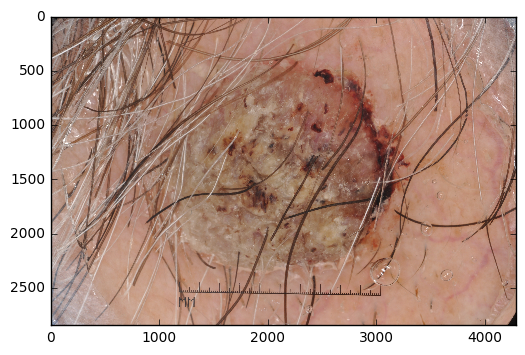

In [1]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import pandas as pd
import numpy as np
from skimage.transform import rescale

%matplotlib inline

random_state = 31415
scale = 0.1
#orig_img = imread('../../ISIC-2017_Training_Data/ISIC_0003056.jpg')
#orig_img = imread('../../ISIC-2017_Training_Data/ISIC_0000056.jpg')
orig_img = imread('../../ISIC-2017_Training_Data/ISIC_0013341.jpg')

img_small = rescale(orig_img, scale, preserve_range=True).astype(np.uint8)
plt.imshow(orig_img)

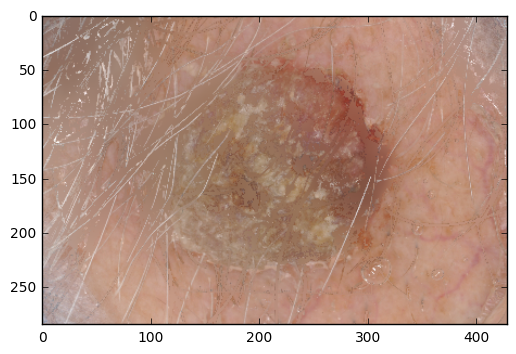

In [2]:
from scipy import ndimage
from skimage.filters.rank import median
from skimage.morphology import disk, black_tophat

mask = disk(30)
img_blurry = img_small.copy()
img_blurry[:,:,0] = median(img_small[:,:,0], mask)
img_blurry[:,:,1] = median(img_small[:,:,1], mask)
img_blurry[:,:,2] = median(img_small[:,:,2], mask)
img_blurry
plt.imshow(img_blurry)

selem = disk(10)
closed = black_tophat(np.mean(img_small,2),  selem)
closed

img_raw = img_small.copy()
val = 40
img_raw[closed>val] = img_blurry[closed>val]
plt.imshow(img_raw)
#img = img_raw

img = img_small

In [3]:
import skfuzzy

def segment_image(n_objects, features):
    cntr, u, u0, d, jm, p, fpc = skfuzzy.cluster.cmeans(data=features.T, c=n_objects, 
                                     m=2, error=0.01, maxiter=1000, seed=random_state)
    return (cntr, u)

features = np.zeros((img.shape[0], img.shape[1], img.shape[2]+2))
max_dim = float(np.amax(img.shape[0:2]))
x = np.linspace(0, img.shape[1]/max_dim, img.shape[1])
y = np.linspace(0, img.shape[0]/max_dim, img.shape[0])
xv, yv = np.meshgrid(x, y)

features[:, :, 0:3] = img_raw
features[:, :, 3] = xv*100
features[:, :, 4] = yv*100

cvecs = features.reshape((features.shape[0]*features.shape[1], features.shape[2]))
cvecs.shape

n_objects = 9
(cntr, u) = segment_image(n_objects, cvecs)

(9, 122265)


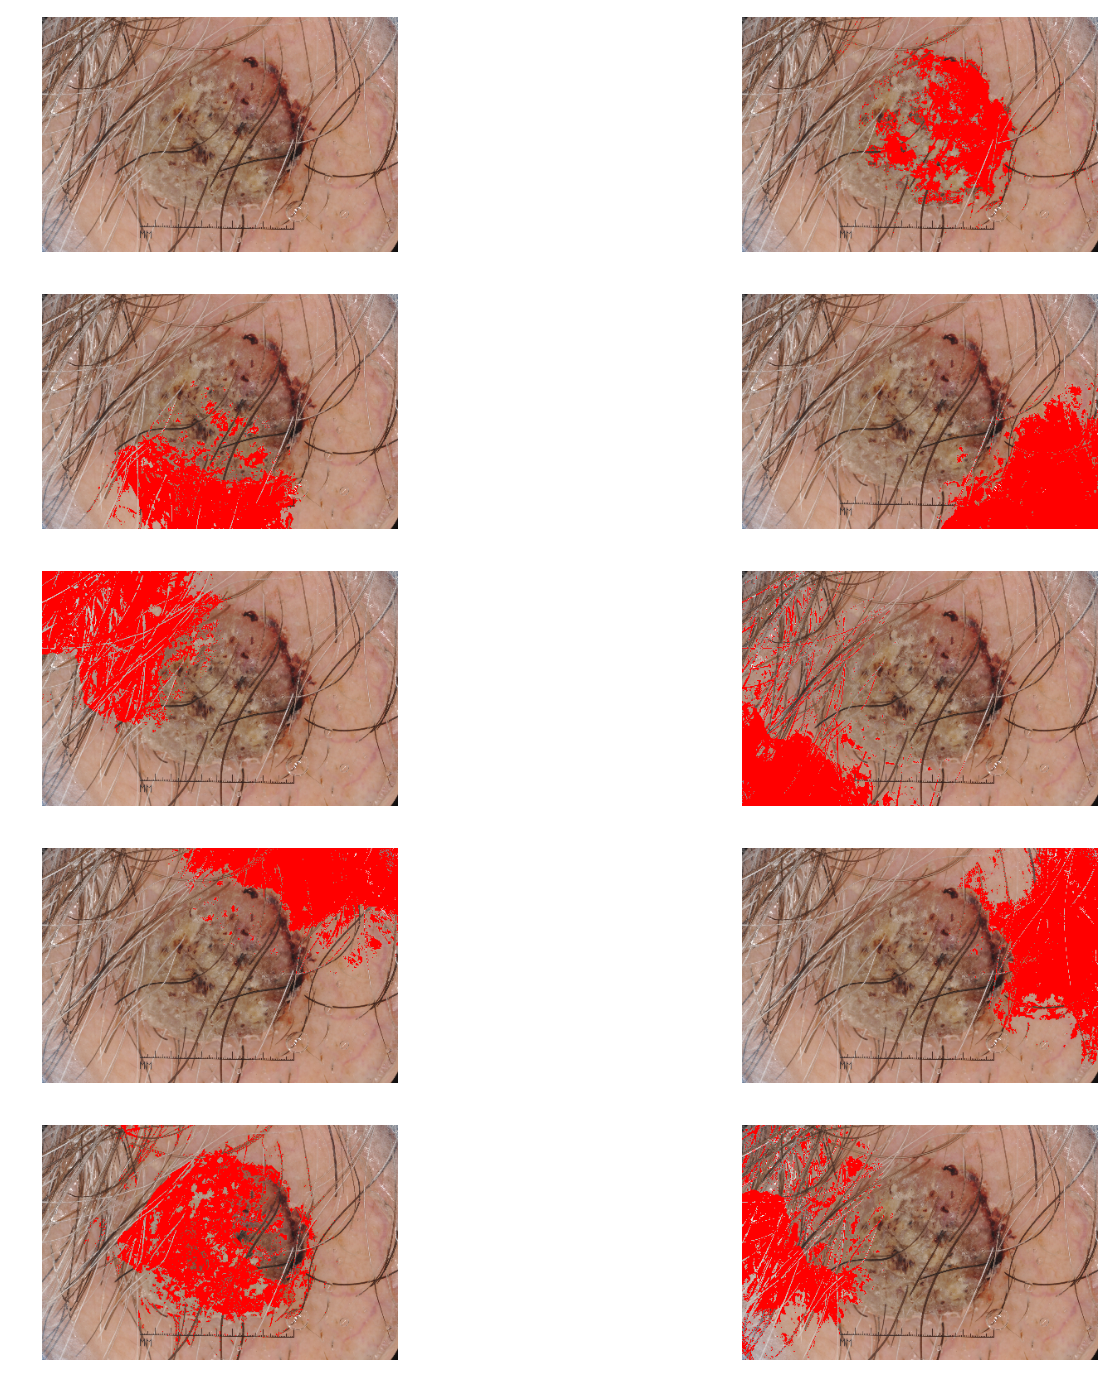

In [4]:
from colorsys import hls_to_rgb

# reference:
# https://stackoverflow.com/questions/37299142/
# how-to-set-a-colormap-which-can-give-me-over-20-distinct-colors-in-matplotlib
def get_distinct_colors(n):

    colors = []

    for i in np.arange(0., 360., 360. / n):
        h = i / 360.
        l = (50 + np.random.rand() * 10) / 100.
        s = (90 + np.random.rand() * 10) / 100.
        colors.append(hls_to_rgb(h, l, s))

    return colors

def identify_objects(n_objects, u, orig_shape):
    col_map = np.array(get_distinct_colors(n_objects))
    fig = plt.figure()
    fig.set_size_inches(17, 14)
    plt.subplot(5, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    print u.shape

    for i in range(n_objects):
        fimg = np.copy(img.reshape(orig_shape[0]*orig_shape[1], orig_shape[2]))
        plt.subplot(5, 2, 2+i)
        #plt.imshow(col_map[kmobjs.labels_].reshape(img.shape))
        fimg[u[i] > 0.2] = [255, 0, 0]
        
        #fimg[u[i] >= np.amax(u,0)] = [1.0, 0.0, 0.0]
        plt.imshow(fimg.reshape(img.shape))
        plt.axis('off')
    plt.tight_layout()

identify_objects(n_objects, u, img.shape)

In [5]:
#Get Features for each cluster
# We look at color (3 values), location (2 values)
# standard_dev (5 values), fraction_of_all_pixels (1 value)
# 'Circular measure' (1 value)



i = 1
cur_cluster = cvecs[u[i] >= np.amax(u,0)]
num_pixels = cur_cluster.shape[0]

# Fraction of pixels within (x^2 + y^2) <= r^2 = n/pi
frac_in_circle = np.count_nonzero((pow((cur_cluster[:,3] - cntr[i, 3])*max_dim, 2) + 
                                   pow((cur_cluster[:,4] - cntr[i, 4])*max_dim, 2)) 
                                  >= cur_cluster.shape[0]/np.pi) / float(num_pixels)

frac_in_circle

0.9999138005344367